# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
#regular libraries
import pandas as pd
import numpy as np
import math
import json

#plot libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
% matplotlib inline

#machine learning library
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
#warnings ignore
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
pd.set_option('display.max_columns', None)

In [80]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==0.23.3
numpy==1.12.1
json==2.0.9
seaborn==0.8.1


# Data Understanding

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [6]:
profile.describe(include='all')

,age,became_member_on,gender,id,income
count,17000.000000,1.700000e+04,14825,17000,14825.000000
unique,NaN,NaN,3,17000,NaN
top,NaN,NaN,M,7d7f271652d244f78b97c73cd734c553,NaN
freq,NaN,NaN,8484,1,NaN
mean,62.531412,2.016703e+07,NaN,NaN,65404.991568
std,26.738580,1.167750e+04,NaN,NaN,21598.299410
min,18.000000,2.013073e+07,NaN,NaN,30000.000000
25%,45.000000,2.016053e+07,NaN,NaN,49000.000000
50%,58.000000,2.017080e+07,NaN,NaN,64000.000000
75%,73.000000,2.017123e+07,NaN,NaN,80000.000000


In [7]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [8]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


# Data Exploration

Below plot shows the distribution of consumer's age

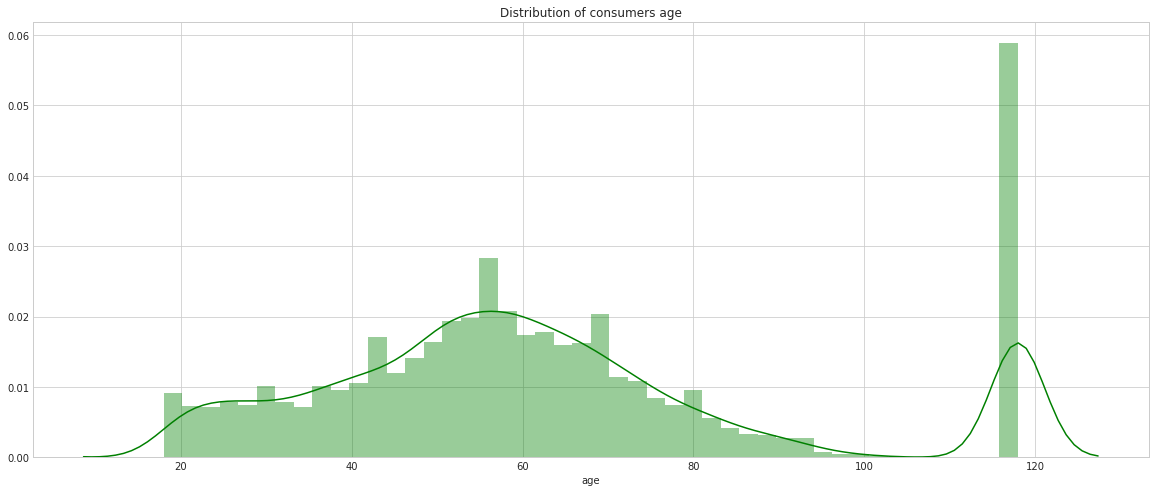

In [9]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(20,8))
sns.distplot(a=profile['age'], color='g', kde = True);
ax.set_title('Distribution of consumers age');

We can see abnormal amount of values near 120. This might be due to Null values replaced with this value. It will be delt in near future code.

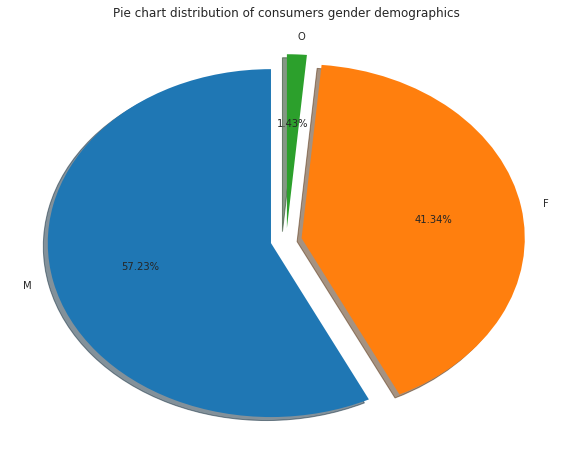

In [10]:
#pie plot of gender distribution
fig, ax = plt.subplots(figsize=(10,8))
plt.pie(profile['gender'].value_counts().values,labels= profile['gender'].value_counts().index, startangle=90, shadow=True,explode=(0.07, 0.07, 0.07), autopct='%1.2f%%');
ax.set_title('Pie chart distribution of consumers gender demographics');

In [11]:
profile[profile.isna().any(axis=1)].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


From above table we can confirm that Null values in age column is replaced with 118. Along with it None for gender column and **NaN** for income column

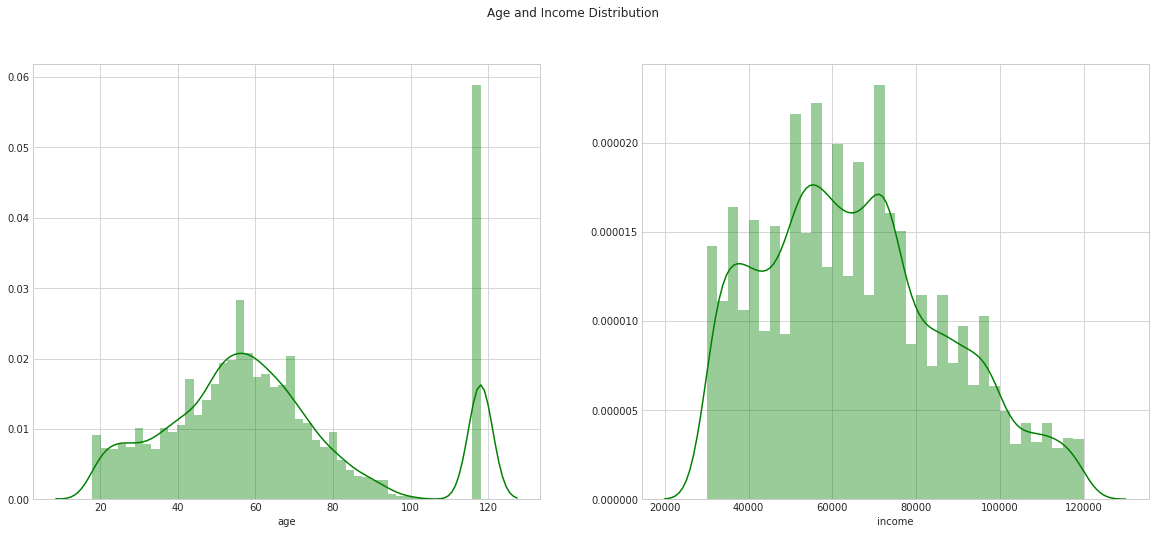

In [12]:
#plotting age and income distribution
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.distplot(a=profile['age'][profile['age'].notnull()], color='g', ax=axes[0]);
sns.distplot(a=profile['income'][profile['income'].notnull()], color='g', ax=axes[1]);
fig.suptitle('Age and Income Distribution');

Above plots are made without Null values includes in it. <br>
From distribution it is clear:
- Since the distribution of age is symetric the null values can be replaced by mean
- Since the distribution of income is left skewed the null values can be replaced by median
<br>
It will be delt in near future code.

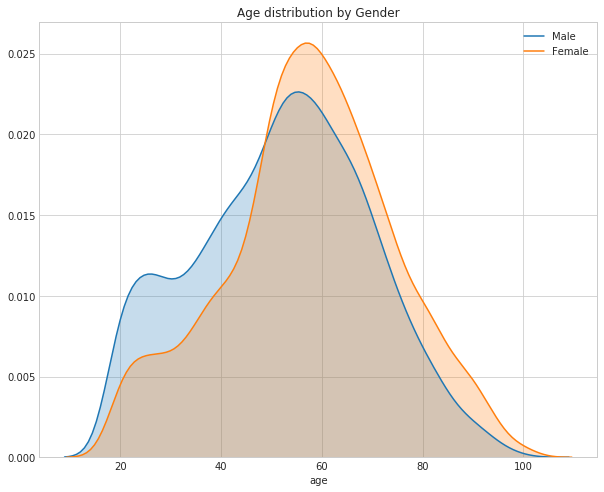

In [13]:
#plotting age distribution by gender
fig, ax = plt.subplots(figsize=(10,8));
sns.distplot(profile[profile['gender']=='M']['age'],hist=False, kde_kws={"shade": True},label = 'Male');
sns.distplot(profile[profile['gender']=='F']['age'],hist=False, kde_kws={"shade": True},label = 'Female');
plt.title('Age distribution by Gender');

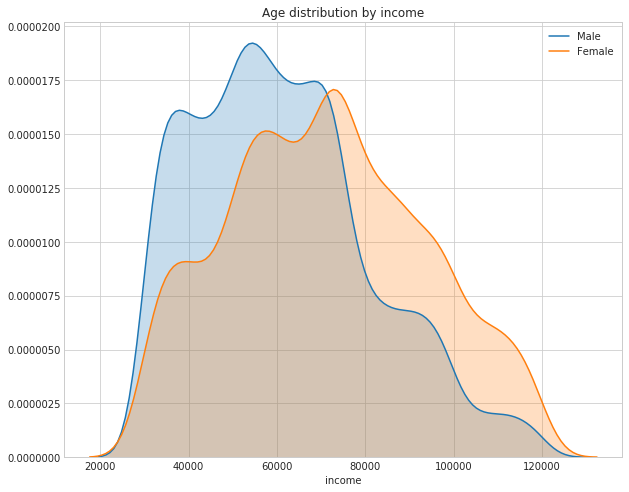

In [14]:
#plotting age distribution by income
fig, ax = plt.subplots(figsize=(10,8));
sns.distplot(profile[profile['gender']=='M']['income'],hist=False, kde_kws={"shade": True}, label = 'Male');
sns.distplot(profile[profile['gender']=='F']['income'],hist=False,kde_kws={"shade": True}, label = 'Female');
plt.title('Age distribution by income');
plt.legend();

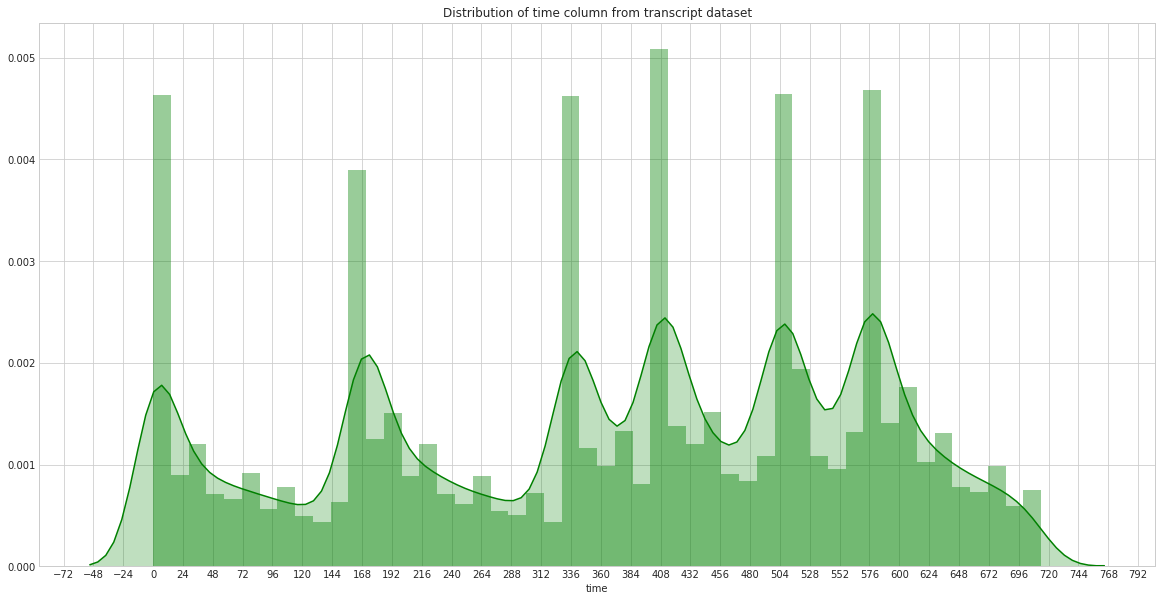

In [15]:
#plot distribution of time column
fig, ax = plt.subplots(figsize=(20,10));
sns.distplot(transcript['time'], color='g', hist = True, kde_kws={"shade": True});
plt.title('Distribution of time column from transcript dataset');
ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

It is clear that distribution follows some pattern. From general knowledge, we know mornings will have high purchase volume from the stores as coffee is used boost the start of workday. Also it is also intutive that mondays will have high purchase volume then rest of the week. 

Since no information is given about what and when the time = 0 starts from the transcript dataset. And since offer notifications, offer views drive purchases.
<br>
**I will assume that time = 0 starts in the morning of Monday**

My assumptions can also be supported from the employees of starbuck's discussion: [Link](https://www.reddit.com/r/starbucks/comments/97nodr/what_are_peak_hours/)

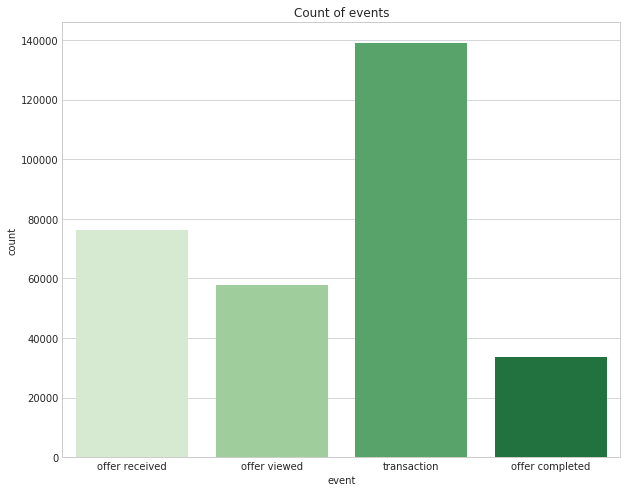

In [16]:
#plot count of events
fig, ax = plt.subplots(figsize=(10,8));
sns.countplot(transcript['event'],palette="Greens");
plt.title('Count of events');

# Preparing Data

Glancing at portfolio dataset..

In [17]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


We can see that channels is in list format. It cannot be used directly, so some preprocessing is required. Below code creates a new column and enters 1 if a particular channel is present or else 0

In [18]:
portfolio['channel_email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['channel_mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['channel_social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
portfolio['channel_web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio.drop(columns=['channels'], inplace=True)

In [19]:
portfolio

,difficulty,duration,id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


As per general knowledge, We know that we try to maximize reward given the difficulty. So I feel the ratio between reward and difficulty feature will help model in prediction. This process is called **Feature Engineering**

In [20]:
#create a column with reward/difficulty ratio and handle NaN values
portfolio['rew_by_diff'] = portfolio['reward']/portfolio['difficulty']
portfolio['rew_by_diff'].fillna(0, inplace=True)

As offer_type is categorical variable for future model prediction it is being encoded

In [21]:
#one-hot encoding
offers = pd.get_dummies(portfolio['offer_type'], prefix ='offer_type', prefix_sep='_')

In [22]:
#concatanate with original dataset
portfolio = pd.concat([portfolio, offers], axis=1)

In [23]:
#remove original offer_type column
portfolio.drop(columns=['offer_type'], inplace=True)

As id from portfolio can be confused with id from profile it is being renamed

In [24]:
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

Glancing at profile dataset..

In [25]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


From earlier comment => age column 118 will be converted to nan and later it will filled using relevant imputation technique like mean in this case

In [26]:
#convert 118 to np.nan
profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
#convert dtype of became_member_on column
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d')

As became_member_on is in pandas datatime dtype but it cannot be used in analysis or in prediction. So it engineered so as to  convert it into an numerical. which will still support same information.

In [27]:
profile['became_member_on'] = (profile['became_member_on'] - profile['became_member_on'].min())/(profile['became_member_on'].max() - profile['became_member_on'].min())

As gender is categorical variable for future model prediction it is being encoded

In [28]:
#one-hot encoding
gender = pd.get_dummies(profile['gender'], prefix ='gender', prefix_sep='_')

In [29]:
#concatenate with orginal dataset. Delete gender column
profile = pd.concat([profile, gender], axis=1)
profile.drop(columns=['gender'], inplace=True)


In [30]:
#For clarity and merging which will be used in later part, The id column is renamed
profile.rename(columns={'id':'consumer_id'}, inplace=True)

In [31]:
#From above discussion we impute age column with mean
profile['age'] = profile['age'].fillna(profile['age'].mean())

In [32]:
#From above discussion we impute age column with median
profile['income'] = profile['income'].fillna(profile['income'].median())

In [33]:
#Function for categorization of age column for further analysis
def age(x):
    if x <= 30:
        return "Young_Adult"
    elif (x>30 and x<=60):
        return "Adult"
    else:
        return "Old"

In [34]:
#Function for categorization of income column for further analysis
def income(x):
    if x <= 50000:
        return "Lower"
    elif (x > 50000 and x <= 90000):
        return "Middle"
    else:
        return "Upper"

In [35]:
#apply the age function
profile['Age_group'] = profile['age'].apply(age)
#one hot encoding
age_column = pd.get_dummies(profile['Age_group'], prefix ='Age_group', prefix_sep='_')
#concatanate with original dataset
profile = pd.concat([profile, age_column], axis=1)
#drop the  Age_group column
profile.drop(columns=['Age_group'], inplace=True)

In [36]:
#Apply the income function
profile['Income_group'] = profile['income'].apply(income)
#one hot enoding
income_column = pd.get_dummies(profile['Income_group'], prefix ='Income_group', prefix_sep='_')
#concatanate with orifinal dataset
profile = pd.concat([profile, income_column], axis=1)
#drop the Income_group column
profile.drop(columns=['Income_group'], inplace=True)

In [37]:
profile.head()

,age,became_member_on,consumer_id,income,gender_F,gender_M,gender_O,Age_group_Adult,Age_group_Old,Age_group_Young_Adult,Income_group_Lower,Income_group_Middle,Income_group_Upper
0,54.393524,0.709819,68be06ca386d4c31939f3a4f0e3dd783,64000.0,0,0,0,1,0,0,0,1,0
1,55.000000,0.793747,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,1,0,0,0,0,1
2,54.393524,0.992320,38fe809add3b4fcf9315a9694bb96ff5,64000.0,0,0,0,1,0,0,0,1,0
3,75.000000,0.756994,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,0,1,0,0,0,1
4,54.393524,0.804717,a03223e636434f42ac4c3df47e8bac43,64000.0,0,0,0,1,0,0,0,1,0


In [38]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 13 columns):
age                      17000 non-null float64
became_member_on         17000 non-null float64
consumer_id              17000 non-null object
income                   17000 non-null float64
gender_F                 17000 non-null uint8
gender_M                 17000 non-null uint8
gender_O                 17000 non-null uint8
Age_group_Adult          17000 non-null uint8
Age_group_Old            17000 non-null uint8
Age_group_Young_Adult    17000 non-null uint8
Income_group_Lower       17000 non-null uint8
Income_group_Middle      17000 non-null uint8
Income_group_Upper       17000 non-null uint8
dtypes: float64(3), object(1), uint8(9)
memory usage: 680.7+ KB


Glancing at transcript dataset..

In [39]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [40]:
#Function for categorization of time column for further analysis
def period(x):
    hour = x%24
    period_internal = int(hour/6)
    if period_internal < 1:
        return "Morning"
    elif (period_internal < 2) and (period_internal >= 1):
        return "Afternoon"
    elif (period_internal < 3) and (period_internal >= 2):
        return "Evening"
    else:
        return "Night"

In [41]:
#Function for categorization of time column for further analysis
def day(x):
    day_internal = int(x/24)
    if day_internal % 7 == 0:
        return "Monday"
    elif day_internal % 7 == 1:
        return "Tuesday"
    elif day_internal % 7 == 2:
        return "Wednesday"
    elif day_internal % 7 == 3:
        return "Thrusday"
    elif day_internal % 7 == 4:
        return "Friday"
    elif day_internal % 7 == 5:
        return "Saturday"
    else:
        return "Sunday"
    

In [42]:
#Apply period function
transcript['period'] = transcript['time'].apply(period)
#one hot encoding
period_column = pd.get_dummies(transcript['period'], prefix ='period', prefix_sep='_')
#concatanate with original dataset
transcript = pd.concat([transcript, period_column], axis=1)
#Will be used in later analysis
df_analysis_6 = transcript.copy()
#drop period column
transcript.drop(columns=['period'], inplace=True)

In [43]:
#Apply day function
transcript['day'] = transcript['time'].apply(day)
#one hot encoding
day_column = pd.get_dummies(transcript['day'], prefix ='day', prefix_sep='_')
#concatanate with original dataset
transcript = pd.concat([transcript, day_column], axis=1)
#Will be used in later analysis
df_analysis_4 = transcript.copy()
#drop period column
transcript.drop(columns=['day'], inplace=True)

In [44]:
transcript.head()

,event,person,time,value,period_Afternoon,period_Evening,period_Morning,period_Night,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thrusday,day_Tuesday,day_Wednesday
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0,1,0,0,0,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0,1,0,0,0,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0,1,0,0,0,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0,1,0,0,0,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0,1,0,0,0,0,0


Value column from this dataset is important as it contains the offer id, reward, amount according to the event. But preprocessing this column is tricky

In [45]:
#As time column is measured in hours this transformation helps in finding trends in weekly as well as monthly distributios
transcript['time'] = transcript['time']/24
transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else (x['offer id'] if 'offer id' in x else None))
num_vals = ['reward','amount']
for i in num_vals:
    transcript[i] = transcript['value'].apply(lambda x:x[i] if i in x else None)
    
transcript.drop('value',axis=1,inplace=True)    

In [46]:
#Average_frequency is engineered feature which will give us idea about how frequent iteractions are happing regarding the campaign
#groupby person , event and apply difference of mean on time column and unstack with suffix
average_frequency = transcript.groupby(by=['person', 'event'])['time'].apply(lambda x: np.mean(np.diff(x))).unstack().add_suffix('_frequency')

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [47]:
#merge it into original dataset
transcript = transcript.merge(average_frequency, on = 'person')

In [48]:
#counts is engineered feature which will give us idea about how many iteractions are happing regarding the campaign
#groupby person , event and apply count of time and unstack with suffix
counts = transcript.groupby(by=['person', 'event'])['time'].count().unstack().add_suffix('_counts')
transcript = transcript.merge(counts, on = 'person')

In [49]:
#average_amount is engineered feature which will give us idea about average amount spent during iteractions int the campaign
#groupby person , amount and apply mean of amount and unstack with suffix
average_amount = transcript.groupby(by=['person'])['amount'].mean().to_frame().rename(columns={'amount':'average_amount'})
transcript = transcript.merge(average_amount, on = 'person')

In [50]:
#count_rewards is engineered feature which will give us idea about count of reward recieved during iteractions int the campaign
#groupby person , reward and apply mean of mean and unstack with suffix
count_rewards = transcript.groupby(by=['person'])['reward'].count().to_frame().rename(columns={'reward':'count_reward'})
transcript = transcript.merge(count_rewards, on = 'person')

In [51]:
#total_amount is engineered feature which will give us idea about total amount spent during iteractions int the campaign
#groupby person , amount and apply sum of amount and unstack with suffix
total_amount = transcript.groupby(by=['person'])['amount'].sum().to_frame().rename(columns={'amount':'total_amount'})
transcript = transcript.merge(total_amount, on = 'person')

In [52]:
transcript.rename(columns={'person': 'consumer_id'}, inplace=True)

In [53]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 28 columns):
event                        306534 non-null object
consumer_id                  306534 non-null object
time                         306534 non-null float64
period_Afternoon             306534 non-null uint8
period_Evening               306534 non-null uint8
period_Morning               306534 non-null uint8
period_Night                 306534 non-null uint8
day_Friday                   306534 non-null uint8
day_Monday                   306534 non-null uint8
day_Saturday                 306534 non-null uint8
day_Sunday                   306534 non-null uint8
day_Thrusday                 306534 non-null uint8
day_Tuesday                  306534 non-null uint8
day_Wednesday                306534 non-null uint8
offer_id                     167581 non-null object
reward                       33579 non-null float64
amount                       138953 non-null float64
offer complete

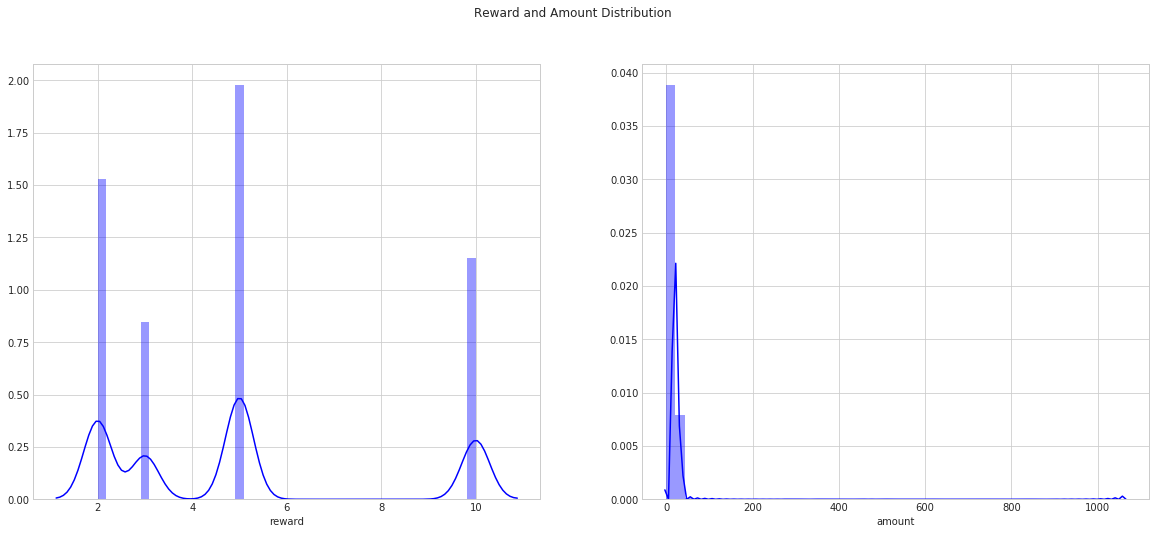

In [54]:
#plot reward and amount distribution
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.distplot(a=transcript['reward'][transcript['reward'].notnull()], color='b', ax=axes[0]);
sns.distplot(a=transcript['amount'][transcript['amount'].notnull()], color='b', ax=axes[1]);
fig.suptitle('Reward and Amount Distribution');

In [55]:
transcript_later = transcript.copy()

In [56]:
#drop reward and amount columns as relevant details are already captured
transcript.drop(columns=['reward', 'amount'], inplace=True)

In [57]:
transcript.fillna(transcript.median(), inplace=True)

**Merging all the dastset into a single master df**

In [58]:
df = transcript.merge(portfolio, how='left', on='offer_id' )
df = df.merge(profile, how='left', on='consumer_id')

In [59]:
df.head()

,event,consumer_id,time,period_Afternoon,period_Evening,period_Morning,period_Night,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thrusday,day_Tuesday,day_Wednesday,offer_id,offer completed_frequency,offer received_frequency,offer viewed_frequency,transaction_frequency,offer completed_counts,offer received_counts,offer viewed_counts,transaction_counts,average_amount,count_reward,total_amount,difficulty,duration,reward,channel_email,channel_mobile,channel_social,channel_web,rew_by_diff,offer_type_bogo,offer_type_discount,offer_type_informational,age,became_member_on,income,gender_F,gender_M,gender_O,Age_group_Adult,Age_group_Old,Age_group_Young_Adult,Income_group_Lower,Income_group_Middle,Income_group_Upper
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.00,0,0,1,0,0,1,0,0,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.875,7.0,8.0,2.791667,3.0,4.0,4.0,7.0,22.752857,3,159.27,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,75.0,0.756994,100000.0,1,0,0,0,1,0,0,0,1
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,0.25,1,0,0,0,0,1,0,0,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.875,7.0,8.0,2.791667,3.0,4.0,4.0,7.0,22.752857,3,159.27,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,75.0,0.756994,100000.0,1,0,0,0,1,0,0,0,1
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,5.50,0,1,0,0,0,0,1,0,0,0,0,None,7.875,7.0,8.0,2.791667,3.0,4.0,4.0,7.0,22.752857,3,159.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,0.756994,100000.0,1,0,0,0,1,0,0,0,1
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,5.50,0,1,0,0,0,0,1,0,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.875,7.0,8.0,2.791667,3.0,4.0,4.0,7.0,22.752857,3,159.27,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,75.0,0.756994,100000.0,1,0,0,0,1,0,0,0,1
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,6.00,0,0,1,0,0,0,0,1,0,0,0,None,7.875,7.0,8.0,2.791667,3.0,4.0,4.0,7.0,22.752857,3,159.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,0.756994,100000.0,1,0,0,0,1,0,0,0,1


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 49 columns):
event                        306534 non-null object
consumer_id                  306534 non-null object
time                         306534 non-null float64
period_Afternoon             306534 non-null uint8
period_Evening               306534 non-null uint8
period_Morning               306534 non-null uint8
period_Night                 306534 non-null uint8
day_Friday                   306534 non-null uint8
day_Monday                   306534 non-null uint8
day_Saturday                 306534 non-null uint8
day_Sunday                   306534 non-null uint8
day_Thrusday                 306534 non-null uint8
day_Tuesday                  306534 non-null uint8
day_Wednesday                306534 non-null uint8
offer_id                     167581 non-null object
offer completed_frequency    306534 non-null float64
offer received_frequency     306534 non-null float64
offer viewed_

Now after merging. For analysis and plotting offer_id contains values which will difficult to interpret so we change into offer{Number}

In [61]:
#list of unique offer_id
unique_ids = list(df['offer_id'].unique())
#saving unique string to each offer_id
for i in range(len(unique_ids)):
    df['offer_id'] = df['offer_id'].apply(lambda x: f'offer{i+1}' if x == unique_ids[i] else x)

In [62]:
df_analysis_1 = df.copy()

As offer_id is categorical variable for future model prediction it is being encoded

In [63]:
#one-hot encoding
offer_ids = pd.get_dummies(df['offer_id'], prefix ='offer_id', prefix_sep='_')
#concatanate with original dataset
df = pd.concat([df, offer_ids], axis = 1)
#drop offer_id column
df.drop(columns=['offer_id'], inplace = True)

# More Data Analysis

# Which channel is effective in acheiveing offer views?

In [64]:
#collect offer viewed data; offer received data along with channels from df
df_analysis_1 = df[df['event'] == 'offer viewed'].iloc[:, 28:32].sum().to_frame().reset_index()
df_analysis_2 = df[df['event'] == 'offer received'].iloc[:, 28:32].sum().to_frame().reset_index()
df_analysis_1.rename(columns = {0:'count_viewed', 'index': 'channel'}, inplace=True)
df_analysis_2.rename(columns = {0:'count_received', 'index': 'channel'}, inplace=True)
#merge both dataset
df_analysis_3 = pd.merge(df_analysis_1, df_analysis_2, on = 'channel')
df_analysis_3['Percent_Viewed'] = (df_analysis_3['count_viewed']/df_analysis_3['count_received'])*100

In [65]:
df_analysis_3

,channel,count_viewed,count_received,Percent_Viewed
0,channel_email,57725.0,76277.0,75.678121
1,channel_mobile,55062.0,68609.0,80.254777
2,channel_social,42629.0,45683.0,93.314800
3,channel_web,44322.0,61001.0,72.657825


So it is clear that Social Media is most effective in acheiving offer views

# What are the best days for offer completions?

In [66]:
df_analysis_4

,event,person,time,value,period_Afternoon,period_Evening,period_Morning,period_Night,day,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thrusday,day_Tuesday,day_Wednesday
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,Monday,0,1,0,0,0,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,Monday,0,1,0,0,0,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,Monday,0,1,0,0,0,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,Monday,0,1,0,0,0,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,Monday,0,1,0,0,0,0,0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,0,1,0,Monday,0,1,0,0,0,0,0
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,0,1,0,Monday,0,1,0,0,0,0,0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,0,1,0,Monday,0,1,0,0,0,0,0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,Monday,0,1,0,0,0,0,0
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,Monday,0,1,0,0,0,0,0


In [67]:
#groupby day and count events
df_analysis_5 = df_analysis_4[df_analysis_4['event'] == 'offer completed'].groupby(by=['day'])['event'].count()

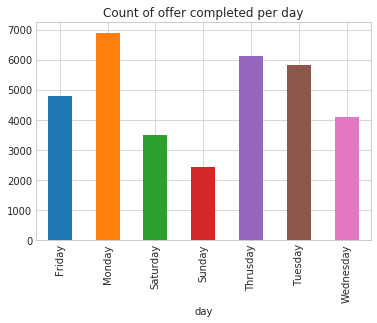

In [68]:
df_analysis_5.plot(kind='bar');
plt.title('Count of offer completed per day');

It is clear that Mondays are best followed by Thrusay and Tuesday

# In what period is most offers completed?

In [69]:
#groupby period and count event
df_analysis_7 = df_analysis_6[df_analysis_6['event'] == 'offer completed'].groupby(by=['period'])['event'].count()

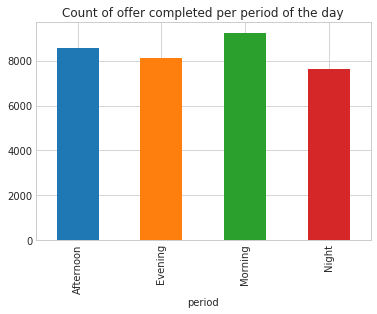

In [70]:
df_analysis_7.plot(kind='bar');
plt.title('Count of offer completed per period of the day');

It is clear that Mornings have most offer completion

# Predictive Model

# What features contribute most for viewing the offer?

In [71]:
df1 = df[((df['event']=='offer received')| (df['event']=='offer viewed'))]

In [72]:
#drop the columsn with no use and with directly contains information of target variable
X1 = df1.drop(columns=['event', 'consumer_id', 'offer viewed_counts', 'offer viewed_frequency'])
Y1 = df1['event'].apply(lambda x: 0 if (x == 'offer received') else 1).reset_index()['event']

In [73]:
X1.shape

(134002, 55)

Below function splits the data into test and train. Graident Boosting Classifier is used because because of its efficacy in dealing with large complex tabular datasets. Finally feature importance will be plotted and model will be returned

In [74]:
def feature_importance(X, Y):
    '''
    Plots important features and return the machine learning model
    Input: 
    X: Dataframe containing the input columns
    Y: Series containing the output column
    Ouput: 
    Returns model fitted on Input data
    '''
    #Split the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 9)
    #initiate the model
    model = GradientBoostingClassifier()
    #fit the data
    model.fit(X_train, Y_train)
    #predict the the test data
    predictions = model.predict(X_test)
    print("Accuracy: %f" % accuracy_score(predictions ,Y_test))
    #store feature importance
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature']).iloc[-15:, :]
    plt.figure(figsize=(25, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)).set(title='Most Important Features')
    plt.tight_layout()
    plt.show()
    return model

Accuracy: 0.903586


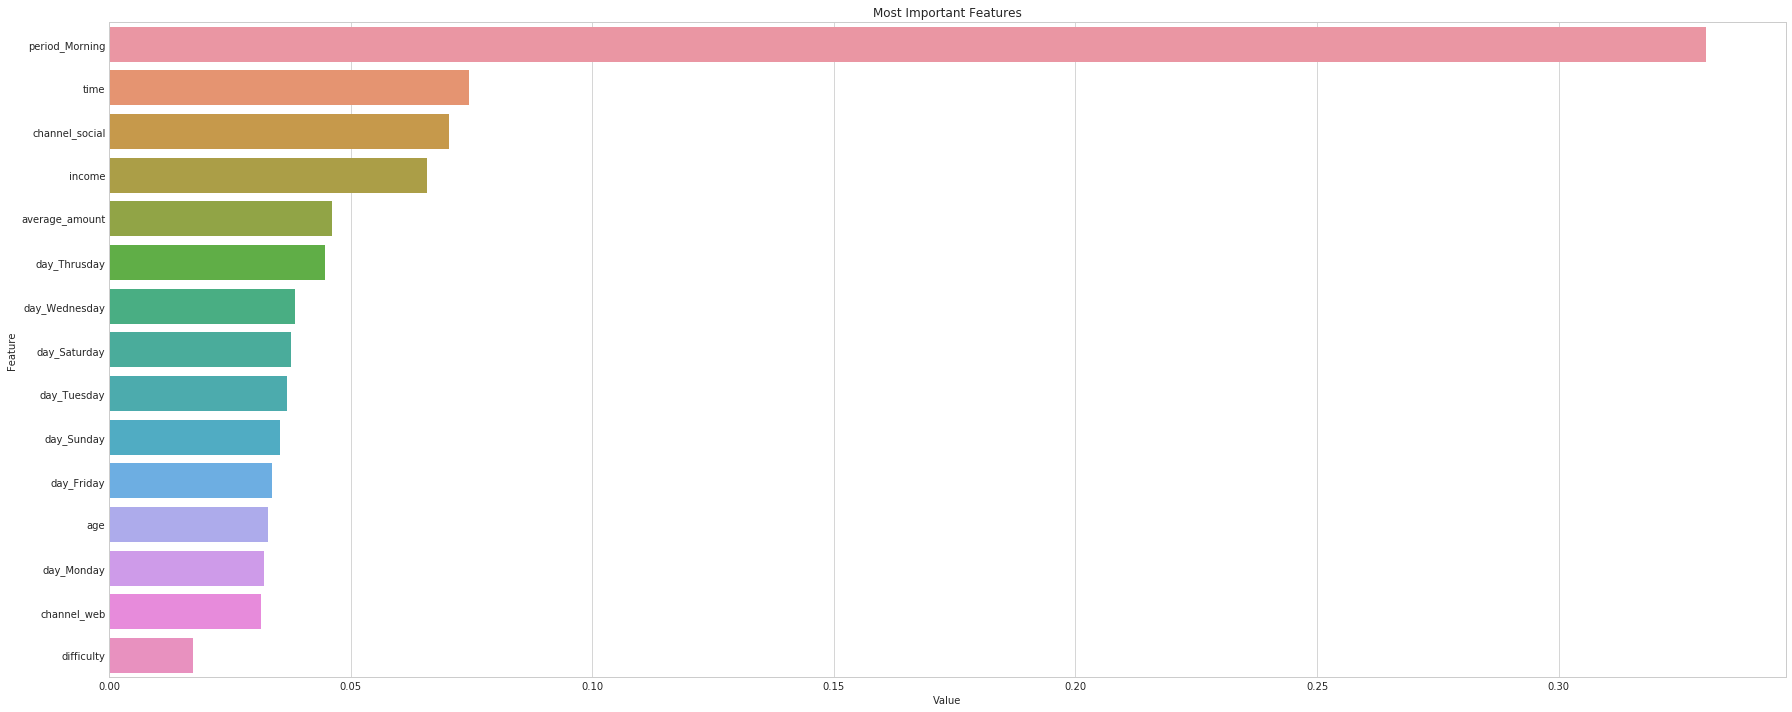

In [75]:
model1 = feature_importance(X1, Y1)

Above Visulization have huge benfit. Following are the insights that can be derived: <br>
- Morning period play important role for offer viewing
- Social Media advertisement is highly effective in offer viewing
- Income and Averge amount spend play role in viewing. 
- Next the day of the week has huge impact on whether the offer is viewed and left alone. This will help in targeting most important offers on particular days

# What features contribute most for completing the offer?

In [76]:
df2 = df[((df['event']=='offer viewed')| (df['event']=='offer completed') | (df['event']=='offer received'))]

In [77]:
df2.head()

,event,consumer_id,time,period_Afternoon,period_Evening,period_Morning,period_Night,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thrusday,day_Tuesday,day_Wednesday,offer completed_frequency,offer received_frequency,offer viewed_frequency,transaction_frequency,offer completed_counts,offer received_counts,offer viewed_counts,transaction_counts,average_amount,count_reward,total_amount,difficulty,duration,reward,channel_email,channel_mobile,channel_social,channel_web,rew_by_diff,offer_type_bogo,offer_type_discount,offer_type_informational,age,became_member_on,income,gender_F,gender_M,gender_O,Age_group_Adult,Age_group_Old,Age_group_Young_Adult,Income_group_Lower,Income_group_Middle,Income_group_Upper,offer_id_offer1,offer_id_offer10,offer_id_offer11,offer_id_offer2,offer_id_offer3,offer_id_offer4,offer_id_offer5,offer_id_offer6,offer_id_offer7,offer_id_offer8,offer_id_offer9
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.00,0,0,1,0,0,1,0,0,0,0,0,7.875,7.0,8.0,2.791667,3.0,4.0,4.0,7.0,22.752857,3,159.27,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,75.0,0.756994,100000.0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,0.25,1,0,0,0,0,1,0,0,0,0,0,7.875,7.0,8.0,2.791667,3.0,4.0,4.0,7.0,22.752857,3,159.27,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,75.0,0.756994,100000.0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,5.50,0,1,0,0,0,0,1,0,0,0,0,7.875,7.0,8.0,2.791667,3.0,4.0,4.0,7.0,22.752857,3,159.27,5.0,7.0,5.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,75.0,0.756994,100000.0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
5,offer received,78afa995795e4d85b5d9ceeca43f5fef,7.00,0,0,1,0,0,1,0,0,0,0,0,7.875,7.0,8.0,2.791667,3.0,4.0,4.0,7.0,22.752857,3,159.27,0.0,3.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,75.0,0.756994,100000.0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
6,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,9.00,0,0,1,0,0,0,0,0,0,0,1,7.875,7.0,8.0,2.791667,3.0,4.0,4.0,7.0,22.752857,3,159.27,0.0,3.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,75.0,0.756994,100000.0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [78]:
#drop the columsn with no use and with directly contains information of target variable
X2 = df2.drop(columns=['event', 'consumer_id'])
Y2 = df2['event'].apply(lambda x: 1 if (x == 'offer completed') else 0).reset_index()['event']

Accuracy: 0.863055


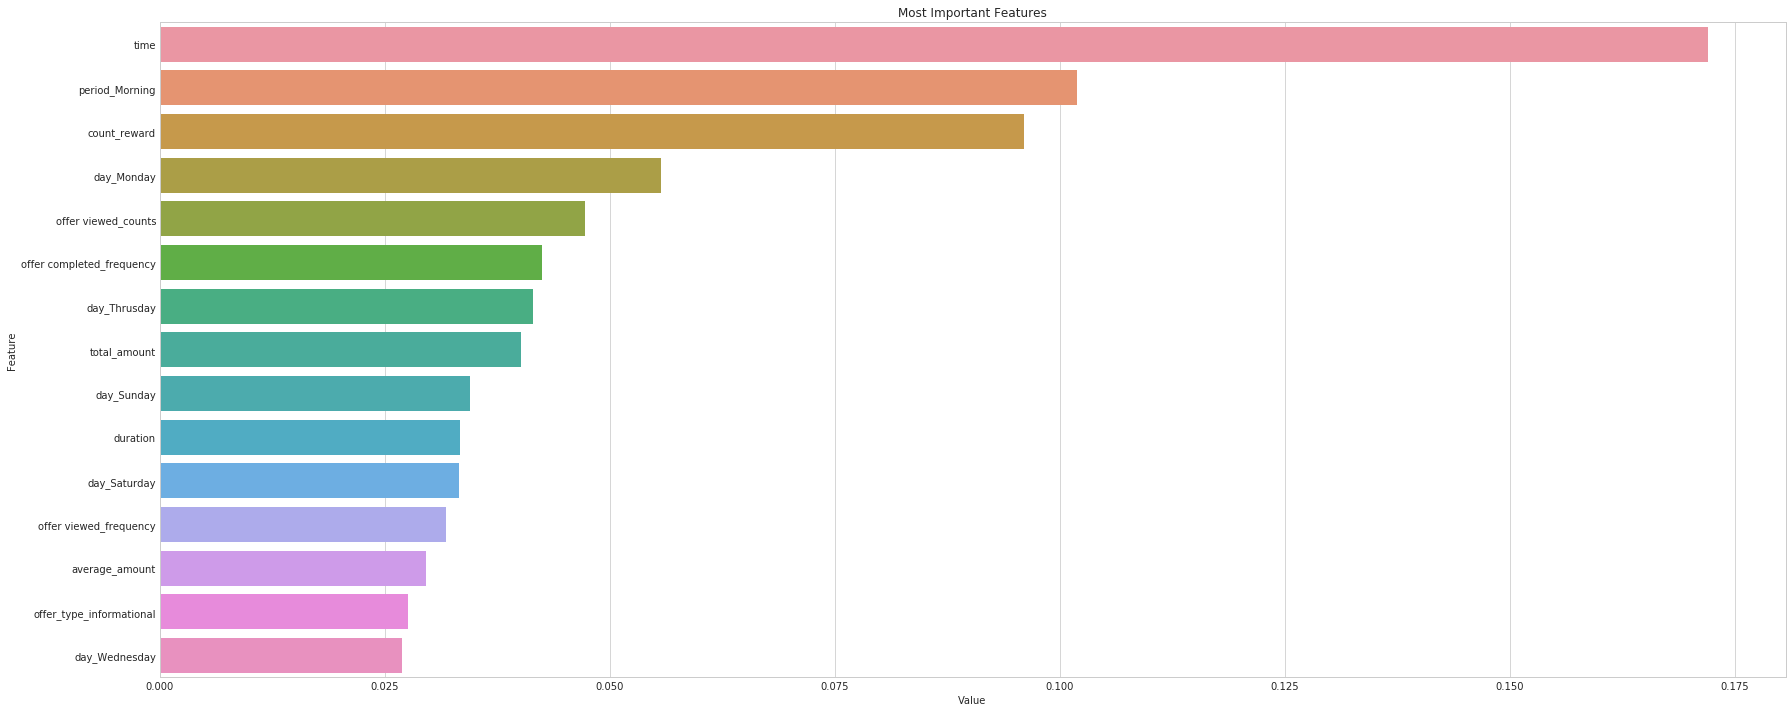

In [79]:
model2 = feature_importance(X2, Y2)

Following insights can be derived from above plot:
- Just like in the case of offer viewing, Morning period play important role in offer completion
- Next, Looking at count reward and offer_completed_count indicates that people keep buying as they recieve rewards and become loyal customers
- It is suprising to offer viewed count and offer viewed frequency indicating that personalized frequent offers sent will impact offer completion
- Thrusday is also important day for offer completion

# Evaluation

Results are showcased in the medium blog post link: 
https://anudeeppeela9.medium.com/starbucks-capstone-challenge-e901baeff5d2